In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from scipy import stats
from scipy.optimize import minimize, curve_fit
from iminuit import Minuit

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

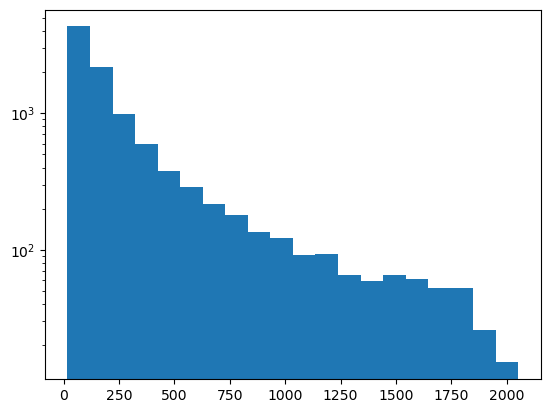

,energy,cosdec,events
0,10.0,0.000000,1986
1,10.0,0.010101,1970
2,10.0,0.020202,1995
3,10.0,0.030303,1977
4,10.0,0.040404,1954
...,...,...,...
9995,100.0,0.959596,35
9996,100.0,0.969697,42
9997,100.0,0.979798,24
9998,100.0,0.989899,35


In [2]:
def atmo_event_rate(energy, cos_theta, sin2theta=0.9, dm2=2.4e-3):
    flux = 1e5*energy**-1.7 # the true neutrino flux is steeper, this takes into account 
                            # neutrino cross-section, which is proportional to E
                            # as well as that we are working with logarithmic energy bins    
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km

    # two flavor oscillation propability for muon disappearance - see wikipedia 
    osc_prop = 1-sin2theta * np.sin(1.27*dm2*l/energy)**2 

    return flux*osc_prop

def run_experiment(energy, cosdec, sin2theta=0.9, dm2=2.4e-3):
    x = np.array(energy.size)
    events=np.zeros(energy.size*cosdec.size)
    rows = []
    i = 0
    for e in energy:
        for c in cosdec:
            mu = atmo_event_rate(e,c,sin2theta,dm2)
            sig = np.sqrt(mu)
            event_random = np.random.normal(mu,sig)
            events[i] = int(event_random) 
            i=i+1
            rows.append([e,c,int(event_random)])
    events_df = pd.DataFrame(rows, columns=['energy','cosdec','events'])
    return events_df

def generate_data(N, sin2theta=0.9, dm2=2.4e-3):
    
    cosdec =  np.linspace(0, 1, N) # N steps in cos(declination) from 0 to 1 
    energy = 10**np.linspace(1, 2, N) # N steps in log10(energy) from 10 to 100 GeV
    
    events_df = run_experiment(energy,cosdec,sin2theta,dm2)
    
    return events_df

events_df = generate_data(100)

plt.hist(events_df["events"], bins=20)
plt.yscale('log')

plt.show() 
events_df

In [3]:
events_df = generate_data(100, sin2theta=0.9, dm2=2.4e-3)

def chi2(sin2theta, dm2):

    energy, cosdec, events = events_df["energy"], events_df["cosdec"], events_df["events"]
    model_events = atmo_event_rate(energy, cosdec, sin2theta, dm2)
    chi2 = np.sum((events - model_events)**2 / model_events)
    return chi2

chi2(0.9, 2.4e-3)

9783.159217472097

In [4]:
m = Minuit(chi2, sin2theta=0.9, dm2=2.4e-3)
print(m.migrad())
print(m.fval)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9781                       │              Nfcn = 31               │
│ EDM = 2.95e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─

In [5]:
N_sim = 1000
chi2_vals =[]
for sim in range(N_sim):
    events_df = generate_data(5, sin2theta=0.9, dm2=2.4e-3)
    
    def chi2(sin2theta, dm2):

        energy, cosdec, events = events_df["energy"], events_df["cosdec"], events_df["events"]
        model_events = atmo_event_rate(energy, cosdec, sin2theta, dm2)
        chi2 = np.sum((events - model_events)**2 / model_events)
        return chi2
    
    m = Minuit(chi2, sin2theta=0.9, dm2=2.4e-3)
    m.migrad()
    chi2_vals.append(m.fval)

print(f"mean, std: {np.mean(chi2_vals):.2f}, {np.std(chi2_vals):.2f}")

mean, std: 23.03, 6.72


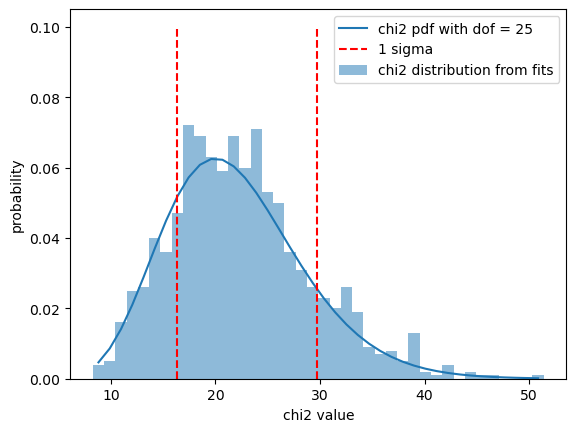

mean of chi2 values: 23.03
std. dev of chi2 values: 6.72
variance of chi2 values: 45.18
69.20% of the fits are within 1 sigma of the mean chi2 value


In [6]:
bins = 40
df=25

bin_height, bin_boundary = np.histogram(chi2_vals, bins=bins)
width = bin_boundary[1]-bin_boundary[0]
bin_height = bin_height/np.sum(bin_height)

chi2_pdf = stats.chi2.pdf(bin_boundary[:-1], df=df)

plt.bar(bin_boundary[:-1],bin_height, width = width, alpha=0.5, label="chi2 distribution from fits")
plt.plot(bin_boundary[:-1], stats.chi2.pdf(bin_boundary[:-1], df=22), label=f"chi2 pdf with dof = {int(df)}")

plt.vlines([np.mean(chi2_vals) + np.std(chi2_vals), np.mean(chi2_vals) - np.std(chi2_vals)], 0, 0.1, color="red", label="1 sigma", ls="--")
plt.xlabel("chi2 value")
plt.ylabel("probability")
plt.legend()
plt.show()

chi2_vals = np.array(chi2_vals)

perc_in_1sigma = len(chi2_vals[np.abs(chi2_vals - np.mean(chi2_vals)) < np.std(chi2_vals)])/len(chi2_vals)*100

print(f"mean of chi2 values: {np.mean(chi2_vals):.2f}")
print(f"std. dev of chi2 values: {np.std(chi2_vals):.2f}")
print(f"variance of chi2 values: {np.var(chi2_vals):.2f}")
print(f"{perc_in_1sigma:.2f}% of the fits are within 1 sigma of the mean chi2 value")


### COVID-19 self-testing and Bayesian theorem

Using Bayes' Theorem, the probability of A occurring given B is:
$$ P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

Where $P(B)$ is the probability of B occurring, and $P(B|A)$ is the probability of B occurring given A.

The probability of a sick person testing positive $P(+|S)$ is 60%, and the false positive rate $P(+|H)$ is 1% (0.01).

The false positive then corresponds to a type I error, i.e rejecting the null hypothesis when it is true.
There is a 40% chance $P(+|S)$ that the test result says that a person is not sick when they actually are (false negative) -- corresponding to a type II error.

In this case, we are interested in the probability of a person being healthy after performing a COVID test. There are two possible outcomes: the test is positive, or the test is negative.

The probability of being healthy given a positive test is:
$$ P(H|+) = \frac{P(+|H)P(H)}{P(+)}$$

where $P(+|H) = 0.01$ is given, and $P(+)$ is the probability of a positive test, which is the sum of the probabilities of a positive test given being healthy and given being sick, respectively:

$$P(+) = P(+|H)P(H) + P(+|S)P(S)$$

where $P(H)$ & $P(S)$ are the probabilities of being healthy and sick, respectively. Further, $P(H)+P(S)=1$. Then:

$$\begin{align} 
P(+) &= P(+|H)(1-P(S)) + P(+|S)P(S) \\ 
&= [P(+|S) - P(+|H)]P(S) + P(+|H)
\end{align}$$

This expression depends explicitly on the COVID prevalence in the general population and the probabilities stated above.

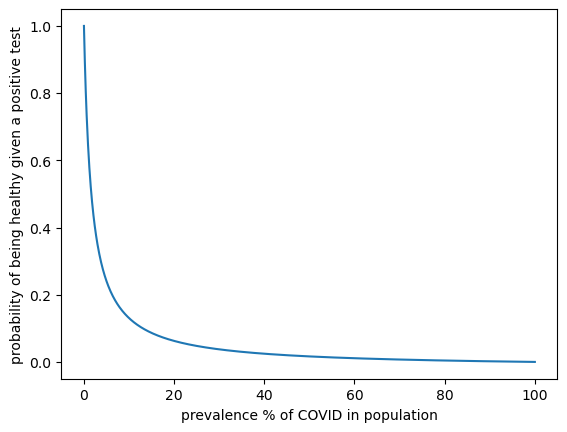

In [7]:
p_sick = np.linspace(1e-6,1,1000) # array of different COVID prevalences

p_positive_sick = 0.6
p_positive_healthy = 0.01

def p_healthy_positive(p_sick, p_positive_sick, p_positive_healthy):
    num = (1-p_sick) * p_positive_healthy
    den = p_sick*(p_positive_sick-p_positive_healthy) + p_positive_healthy
    return num/den

plt.plot(p_sick*100, p_healthy_positive(p_sick, p_positive_sick, p_positive_healthy))
plt.xlabel("prevalence % of COVID in population")
plt.ylabel("probability of being healthy given a positive test")
plt.show()

Now we consider the probability of being healthy given a negative test:

$$ P(H|-) = \frac{P(-|H)P(H)}{P(-)}$$

where $P(-|H) = 0.99$ is given, and $P(-)$ is the probability of a negative test, which is the sum of the probabilities of a negative test given being healthy and given being sick, respectively:

$$P(-) = P(-|H)P(H) + P(-|S)P(S)$$

where $P(H)$ & $P(S)$ are the probabilities of being healthy and sick, respectively. Further, $P(H)+P(S)=1$. Then:

$$\begin{align}
P(-) &= P(-|H)(1-P(S)) + P(-|S)P(S) \\
&= [P(-|S) - P(-|H)]P(S) + P(-|H)
\end{align}$$

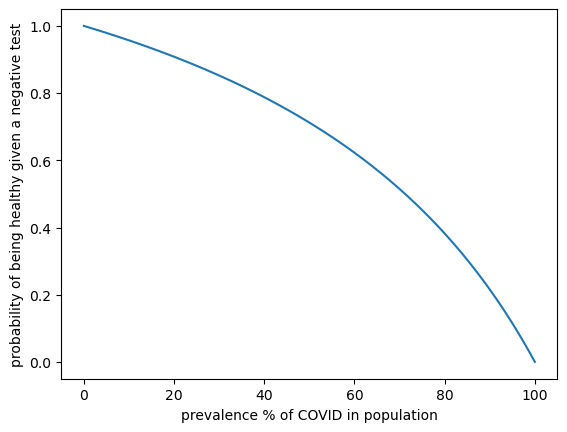

In [8]:
def p_healthy_negative(p_sick, p_positive_sick, p_positive_healthy):
    num = (1-p_sick) * (1-p_positive_healthy)
    den = ((1-p_positive_sick)-(1-p_positive_healthy)) * p_sick + (1-p_positive_healthy)
    return num/den

plt.plot(p_sick*100, p_healthy_negative(p_sick, p_positive_sick, p_positive_healthy))
plt.xlabel("prevalence % of COVID in population")
plt.ylabel("probability of being healthy given a negative test")
plt.show()

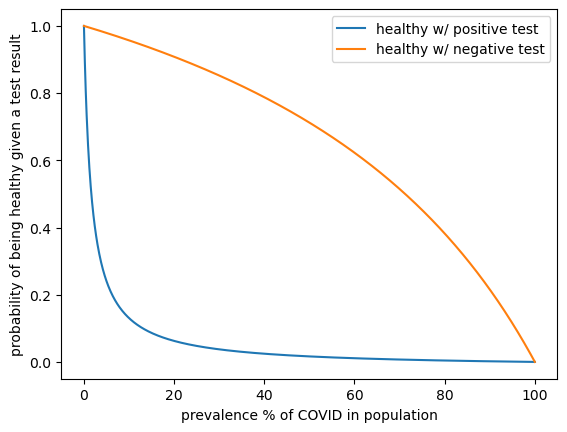

In [9]:
plt.plot(p_sick*100, p_healthy_positive(p_sick, p_positive_sick, p_positive_healthy), label="healthy w/ positive test")
plt.plot(p_sick*100, p_healthy_negative(p_sick, p_positive_sick, p_positive_healthy), label="healthy w/ negative test")

plt.ylabel("probability of being healthy given a test result")
plt.xlabel("prevalence % of COVID in population")
plt.legend()
plt.show()